In [1]:
from collections import defaultdict
import glob

import matplotlib.pyplot as plt
import numpy as np

from s1denoise import Sentinel1Image

In [2]:
# Modified: 27/10/2020 by AK
#
# In this quick start practical tutorial, you will learn how to get the power factors from S1 Level-1 GRD data.
# The processing comprises two stages. 1st is related to the method called 'experiment_powerBalancing'
# of the 'Sentinel1Image' class to obtain statistics for an each individual training file.
# The aggregated statistics processing is the second stage of the method and implemnted as a
# python script called 'analyze_experiment_powerBalancingParameters.py'.
# In this tutorial we follow the mentioned implementation almost line by line.

In [3]:
# Pre-requerments: It is assumed that you have dowmloaded and installed Sentinel1Denoised package:
# https://github.com/nansencenter/sentinel1denoised/tree/master

In [4]:
########################################################################
# Stage 1. Processing of individual training files (S1 Level-1 GRD)  #
########################################################################

In [5]:
# First you need to import Sentinel1Image class and open 
# a S1 Level1 GRD file (IW GRDH in our case, replace with yours)
# Note: In our example we process the only one training file but in real data processing you need to use tens of files
# in batch manner

# Define filename and polarization of the data we want to process
input_file = '/data1/antonk/tmp/S1B_EW_GRDM_1SDH_20190810T164042_20190810T164124_017526_020F60_7343.SAFE'
polarization = 'HV'

#input_file = '/mnt/sverdrup-2/sat_auxdata/denoise/dolldrums/zip/S1A_IW_GRDH_1SDV_20200607T075151_20200607T075220_032908_03CFD7_9E14.zip'
#polarization = 'VH'

s1 = Sentinel1Image(input_file)

In [6]:
# We further go almost in line by line manner through the method called 'experiment_powerBalancing'

In [7]:
# Clip size of side pixels, ~1km
cPx = {'IW':100, 'EW':25}[s1.obsMode]
num_swaths = {'IW':3, 'EW':5}[s1.obsMode]

In [8]:
# Call 'subswathIndexMap' method to get matrix with sub-swath numbers
# consistent with the data grid
subswathIndexMap = s1.subswathIndexMap(polarization)

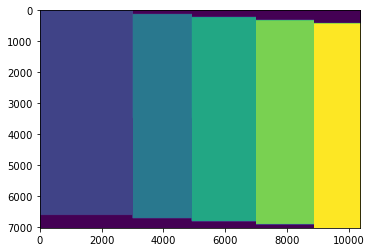

In [9]:
# Lets visualize the sub-swath numbers
# Color corresponds to different sub-swath. In our case:
# blue - 1, green - 2, yellow - 3, black - no data
plt.clf()
plt.imshow(subswathIndexMap)

In [10]:
# Get matrices of calibrated raw sigma zero and NESZ from ESA-provided annotaion files
sigma0 = s1.rawSigma0Map(polarization)
rawNoiseEquivalentSigma0 = s1.rawNoiseEquivalentSigma0Map(polarization)

In [11]:
# Import the noise scaling coefficients and scale the noise
# to a matrix called 'noiseEquivalentSigma0'
# The scaling is applied separetely for each sub-swath

noiseEquivalentSigma0 = np.zeros_like(rawNoiseEquivalentSigma0)
noiseScalingParameters = s1.import_denoisingCoefficients(polarization)[0]

for iSW in range(1, num_swaths+1):
    swathname = '%s%s' % (s1.obsMode, iSW)
    scale = noiseScalingParameters[swathname]
    print(swathname, scale)
    valid = (subswathIndexMap==iSW)
    noiseEquivalentSigma0[valid] = rawNoiseEquivalentSigma0[valid] * scale

EW1 0.9114866249336492
EW2 0.8728371017173528
EW3 0.8338695690167017
EW4 0.8879468615328421
EW5 0.8897685557797818


In [12]:
# Get the line indexes where we have data for each element in range ditrection
validLineIndices = np.argwhere(np.sum(subswathIndexMap!=0,axis=1)==s1.shape()[1])

In [13]:
# Define number of lines to averge (block height), in our case 1000 px
# and calculate the block bounds
numberOfLinesToAverage = 1000
blockBounds = np.arange(validLineIndices.min(), validLineIndices.max(),
                                numberOfLinesToAverage, dtype='uint')

In [14]:
# Print out block bounds coordinates (pixel indexes)
blockBounds

array([ 422, 1422, 2422, 3422, 4422, 5422, 6422], dtype=uint64)

In [15]:
# Prepare a dictonary for results for each sub-block
# sigma0 is a vector with the mean range profile
# noiseEquivalentSigma0 is a vector with the mean range profile of ESA-provided noise
# balancingPower is a value of intermediate balancing power
# correlationCoefficient is a value of correlation coefficient between raw sigma0 and the scaled noise
# fitResidual is a value of optimization residual
results = { '%s%s' % (s1.obsMode, li): defaultdict(list) for li in range(1, num_swaths+1) }

In [16]:
# Loop over blocks
for iBlk in range(len(blockBounds)-1):   
    # Slicing 2D arrays for each block
    # sigma0
    blockS0 = sigma0[blockBounds[iBlk]:blockBounds[iBlk+1],:]   
    # Scaled noise
    blockN0 = noiseEquivalentSigma0[blockBounds[iBlk]:blockBounds[iBlk+1],:]
    # Raw ESA noise
    blockRN0 = rawNoiseEquivalentSigma0[blockBounds[iBlk]:blockBounds[iBlk+1],:]
    # Sub-swath indices for the block
    blockSWI = subswathIndexMap[blockBounds[iBlk]:blockBounds[iBlk+1],:]
    
    # An arbitrary empirical adjustment.
    # When the number of valid range pixels is too small, it is hard to get reliable estimation.
    # By allowing the use of some pixels with negative values, the number of range pixels to be used 
    # for fitting increases.
    # In short, it can be any value but we set it as 0.5 for no special reason.
    pixelValidity = (np.nanmean(blockS0 - blockRN0 * 0.5, axis=0) > 0) 
    if pixelValidity.sum() <= (blockS0.shape[1] * 0.9):
        continue

    fitCoefficients = []
    
    # Loop over sub-blocks
    for iSW in range(1, num_swaths+1):
        subswathID = '%s%s' % (s1.obsMode, iSW)
        # Get valid pixel indices based on 'pixelValidity'
        pixelIndex = np.nonzero((blockSWI==iSW).sum(axis=0) * pixelValidity)[0][cPx:-cPx]
        if pixelIndex.sum()==0:
            continue
            
        # Compute vectors with mean range profiles for sub-block by averaging in azimuth direction
        meanS0 = np.nanmean(np.where(blockSWI==iSW, blockS0, np.nan), axis=0)[pixelIndex]
        meanN0 = np.nanmean(np.where(blockSWI==iSW, blockN0, np.nan), axis=0)[pixelIndex]
        meanRN0 = np.nanmean(np.where(blockSWI==iSW, blockRN0, np.nan), axis=0)[pixelIndex]
        
        # Do fitting for a difference between sigma0 and scaled noise
        fitResults = np.polyfit(pixelIndex, meanS0 - meanN0, deg=1, full=True)
        
        # Store slope value for further calculations
        fitCoefficients.append(fitResults[0])
        
        # Store results
        results[subswathID]['sigma0'].append(meanS0)
        results[subswathID]['noiseEquivalentSigma0'].append(meanRN0)
        results[subswathID]['correlationCoefficient'].append(np.corrcoef(meanS0, meanN0)[0,1])
        results[subswathID]['fitResidual'].append(fitResults[1].item())
        results[subswathID]['noiseEquivalentSigma0Scaled'].append(meanN0)
        results[subswathID]['pixelIndex'].append(pixelIndex)
        results[subswathID]['fitResults'].append(fitResults)
    
    # Initialize a vector with zeros for each sub-swath 
    balancingPower = np.zeros(num_swaths)

    # Loop over sub-swath margins
    for li in range(len(s1.import_swathBounds(polarization))-1):
        # Calculate pixel coordinate of interswath boundary
        interswathBounds = (np.where(np.gradient(blockSWI, axis=1) == 0.5)[1]
                            .reshape((num_swaths - 1) * numberOfLinesToAverage, 2)[li::4].mean())
        # Compute power value left to a boundary as slope*interswathBounds + residual coef.
        power1 = fitCoefficients[li][0] * interswathBounds + fitCoefficients[li][1]
        # Compute power value right to a boundary as slope*interswathBounds + residual coef.
        power2 = fitCoefficients[li+1][0] * interswathBounds + fitCoefficients[li+1][1]
        # Compute balancing power vector as a power difference between the powers in neighboring sub-swaths
        balancingPower[li+1] = power2 - power1
        
    # Compute cumulative sum vector of of the balancing power near sub-swath margins
    balancingPower = np.cumsum(balancingPower)

    # Loop through sub-swaths to offset noise power for the each one
    for iSW in range(1, num_swaths+1):
        valid = (blockSWI==iSW)
        blockN0[valid] += balancingPower[iSW-1]

    # Value of the mean of the difference bewtween noise matrices for block across sub-swaths >=2
    powerBias = np.nanmean((blockRN0-blockN0)[blockSWI>=2])
    
    # Add the mean to the balancing power vector
    balancingPower += powerBias

    for iSW in range(1, num_swaths+1):
        results['%s%s' % (s1.obsMode, iSW)]['balancingPower'].append(balancingPower[iSW-1])

# Save results for individual file in NPZ format
np.savez(s1.name.split('.')[0] + '_powerBalancing.npz', **results)

# At this point we obtained statistics for many files and ready for the 2nd stage that is
# aggregated statistics processing

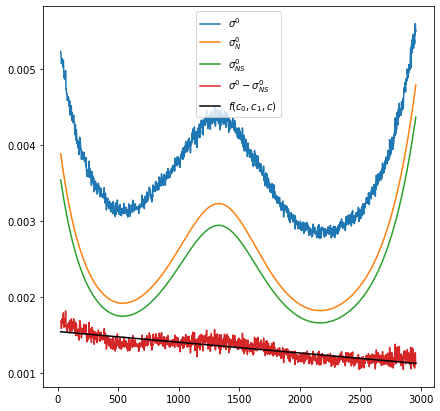

In [30]:
# plot range profiles of sigma zero, NESZ, denoised signal, and approximated denoised signal in one sub-swath

j = 0                        # sub-block index
i = list(results.keys())[0]  # sub-swath name

# scaled denoised signal
meanS0ij = results[i]['sigma0'][j] - results[i]['noiseEquivalentSigma0Scaled'][j]

# approximated signal
meanS0ij_fit = np.polyval(results[i]['fitResults'][j][0], results[i]['pixelIndex'][j])

plt.figure(figsize=(7,7))
plt.plot(results[i]['pixelIndex'][j], results[i]['sigma0'][j], label='$\sigma^0$')
plt.plot(results[i]['pixelIndex'][j], results[i]['noiseEquivalentSigma0'][j], label='$\sigma^0_N$')
plt.plot(results[i]['pixelIndex'][j], results[i]['noiseEquivalentSigma0Scaled'][j], label='$\sigma^0_{NS}$')
plt.plot(results[i]['pixelIndex'][j], meanS0ij, label='$\sigma^0 - \sigma^0_{NS}$')
plt.plot(results[i]['pixelIndex'][j], meanS0ij_fit, 'k-', label='$f(c_0, c_1, c)$')
plt.legend()
plt.show()

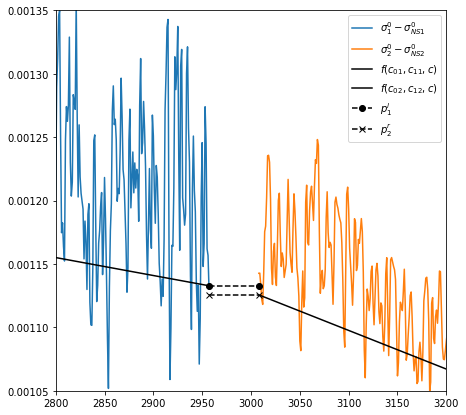

In [32]:
# plot range profiles of denoised signal, and approximated denoised signal in two sub-swaths
j = 0                          # sub-block index
i1 = list(results.keys())[0]   # sub-swath name
i2 = list(results.keys())[1]   # sub-swath name

# denoised_signal
meanS01j = results[i1]['sigma0'][j] - results[i1]['noiseEquivalentSigma0Scaled'][j]
meanS02j = results[i2]['sigma0'][j] - results[i2]['noiseEquivalentSigma0Scaled'][j]

# approximated signal
meanS01j_fit = np.polyval(results[i1]['fitResults'][j][0], results[i1]['pixelIndex'][j])
meanS02j_fit = np.polyval(results[i2]['fitResults'][j][0], results[i2]['pixelIndex'][j])

# approximated signal at boundary
c_left = results[i1]['pixelIndex'][j][-1]
p1_left =  np.polyval(results[i1]['fitResults'][j][0], c_left)
c_right = results[i2]['pixelIndex'][j][0]
p2_right = np.polyval(results[i2]['fitResults'][j][0], c_right)

plt.figure(figsize=(7,7))
plt.plot(results[i1]['pixelIndex'][j], meanS01j, label='$\sigma^0_1 - \sigma^0_{NS1}$')
plt.plot(results[i2]['pixelIndex'][j], meanS02j, label='$\sigma^0_2 - \sigma^0_{NS2}$')
plt.plot(results[i1]['pixelIndex'][j], meanS01j_fit, 'k-', label='$f(c_{01}, c_{11}, c)$')
plt.plot(results[i2]['pixelIndex'][j], meanS02j_fit, 'k-', label='$f(c_{02}, c_{12}, c)$')

plt.plot([c_left, c_right], [p1_left, p1_left], 'ko--', label='$p_1^l$')
plt.plot([c_left, c_right], [p2_right, p2_right], 'kx--', label='$p_2^r$')

plt.xlim([2800, 3200])
plt.ylim([0.00105, 0.00135])
plt.legend()
plt.show()


In [19]:
################################################
# Stage 2. Processing of aggregated statistics
################################################

In [20]:
# Once we have statistics for the training files we may start to get final results on the power balancing

In [21]:
# Initialize empty lists for results from each npz file
powerDifference = []
balancingPower = []
correlationCoefficient = []
fitResidual = []

In [22]:
# Get the list of npz files with individual statistics
npzFiles = glob.glob('*powerBalancing*.npz')

# Loop over the files
for npzFile in npzFiles:
    print('importing %s' % npzFile)
    npz = np.load(npzFile)
    npz.allow_pickle = True
    # Number of sub-blocks in sub-swath
    numberOfSubblocks = np.unique([ len(npz['%s%s' % (s1.obsMode,iSW)].item()['balancingPower'])
                                    for iSW in range(1,({'IW': 3, 'EW': 5}[s1.obsMode]+1)) ])
    
    # Check if a number of sub-blocks are not consistent for all subswaths
    if numberOfSubblocks.size != 1:
        print('*** numberOfSubblocks are not consistent for all subswaths.')
        continue
    
    # Unpack the number of sub-blocks
    numberOfSubblocks = numberOfSubblocks.item()
    
    # Loop over each sub-block
    for li in range(numberOfSubblocks):
        # Values of intermediate sigma0
        powerDifference.append([
              np.nanmean(10*np.log10(npz['%s%s' % (s1.obsMode,iSW)].item()['sigma0'][li]))
            - np.nanmean(10*np.log10(npz['%s%s' % (s1.obsMode,iSW)].item()['noiseEquivalentSigma0'][li]))
            for iSW in range(1,({'IW': 3, 'EW': 5}[s1.obsMode])+1) ])
        
        # Values of balancing power
        balancingPower.append([
            npz['%s%s' % (s1.obsMode,iSW)].item()['balancingPower'][li]
            for iSW in range(1,({'IW': 3, 'EW': 5}[s1.obsMode])+1) ])
        
        # Values of balancing correlation coefficient
        correlationCoefficient.append([
            npz['%s%s' % (s1.obsMode,iSW)].item()['correlationCoefficient'][li]
            for iSW in range(1,({'IW': 3, 'EW': 5}[s1.obsMode])+1) ])
        
        # Values of residuals
        fitResidual.append([
            npz['%s%s' % (s1.obsMode,iSW)].item()['fitResidual'][li]
            for iSW in range(1,({'IW': 3, 'EW': 5}[s1.obsMode])+1) ])

importing S1A_EW_GRDM_1SDH_20201002T070633_20201002T070710_034614_0407C6_3CF7_powerBalancing.npz
importing S1B_EW_GRDM_1SDH_20190810T164042_20190810T164124_017526_020F60_7343_powerBalancing.npz


In [23]:
# After the loop, convert the aggregated lists to Numpy arrays
powerDifference = np.array(powerDifference)
balancingPower = np.array(balancingPower)
correlationCoefficient = np.array(correlationCoefficient)
fitResidual = np.array(fitResidual)

In [24]:
# Now we ready to compute fit values for each sub-swath based on aggregated statistics which are the power balancing factors
# and their confident intervals
powerBalancingParameters = {'%s%s' % (s1.obsMode,li): {} for li in range(1,({'IW': 3, 'EW': 5}[s1.obsMode]+1))}
powerBalancingParametersRMSE = {'%s%s' % (s1.obsMode,li): {} for li in range(1,({'IW': 3, 'EW': 5}[s1.obsMode]+1))}

In [25]:
# Compute vectors which are the mean across all sub-swath for each sub-block
pd = np.mean(powerDifference, axis=1)
cc = np.min(correlationCoefficient, axis=1)
fr = np.max(fitResidual, axis=1)
# Vector of weight factor for fitting
w = cc / fr

In [26]:
# Loop over sub-swaths for fitting vectors of mean values of power difference across all sub-swaths
# with balanacing power vector for a given sub-swath
for iSW in range(1,({'IW': 3, 'EW': 5}[s1.obsMode])+1):
    bp = balancingPower[:,iSW-1]
    fitResults = np.polyfit(pd, bp, deg=0, w=w)
    powerBalancingParameters['%s%s' % (s1.obsMode,iSW)] = fitResults[0]
    powerBalancingParametersRMSE['%s%s' % (s1.obsMode,iSW)] = np.sqrt(np.sum((fitResults[0]-bp)**2 * w) / np.sum(w))

In [27]:
# Now we finished with the whole processing chain and obtained the power balancing factors for each sub-swath
# and their RMSE (can be considered as confident inetrval for the factor)
print('Power balancing factors:\n%s' % powerBalancingParameters)
print('\nRMSE of the power balancing factors:\n%s' % powerBalancingParametersRMSE)

Power balancing factors:
{'EW1': 7.052583256963947e-05, 'EW2': 4.8308662169424475e-05, 'EW3': 0.00012144456800332162, 'EW4': 0.00012555967588234336, 'EW5': 0.0001650869621556632}

RMSE of the power balancing factors:
{'EW1': 0.00014067712365663877, 'EW2': 0.00013396745759879962, 'EW3': 9.810648737355323e-05, 'EW4': 9.800812701514275e-05, 'EW5': 9.493365769401423e-05}
